# Estatística Bayesiana e Regressão Logística no IBOVESPA: Como prever a direção do retorno do IBOVESPA nos modelos Logit e splits do Logit, LDA, QDA e KNN?

Qual a probabilidade da alta ou baixa do retorno de um ativo visto os retornos no dia de hoje, de 2,3,7,15 e 30 dias, preço de fechamento ajustado e Volume de negociações?

Qual a probabilidade de jogar bola à tarde, sabendo que irá chover de manhã?

Qual a probabilidade da existência de Deus visto o desenvolvimento científico, a escritura de livros sagrados, o Holocasto, o nascimento de um filho ou a redenção médica de uma doença tida como incurável?

Sharon Mcgrayne, uma autora científica, escreveu em 2015 o livro "A teoria que não morreria: como a lei de Bayes decifrou o código enigma, perseguiu submarinos russos e emergiu triunfante de dois séculos de controvérsias".

No livro, Mcgrayne trás o desenvolvimento das ideias de Thomas Bayes ao formular a Estatística Bayesiana, uma regra estatística inversa da probabilidade condicional. Além disso, atualiza as influências desse modelo na Física, Ciências da Computação, e outros.

Qual a probabilidade de acontecimento do evento A visto que tenho dados agora do acontecimento do evento B posterior a ele e que o influencia?

As ideias bayesianas estão por trás de alguns modelos e classificadores de Regressão Logística, como por exemplo medir a probabilidade da variável preditora Direção do retorno diário do Ibovespa (tendência de alta ou baixa) pertencer a uma categoria particular de variáveis dependentes, como retorno do ibovespa no dia de hoje, em 2, 3, 7, 15, 30 dias, preço de fechamento ajustado e Volume.

Num primeiro momento decidimos treinar toda a base de dados pelo modelo Logístico Logit e incluir todas as variáveis no modelo. Posteriormente, ao observarmos multicolinearidade entre a feature "retorno_hoje" e a variável preditiva "direção_hoje", além de um p-valor estatisticamente significante para os retornos de 2 e 3 dias, decidimos pelo split data antes e após o COVID (considerando final de 2019).

Como a Regressão Logística é um modelo que trabalha em conjunto com a matriz de confusão, a conclusão e consequente interpretação da tabela é individualizada ao problema em questão.  

A Precisão é o indicador mais relevante nesse estudo, sendo a quantidade de retornos positivos e negativos que o modelo previu corretamente.

Os dados splitados treinados antes da pandemia (e testados após) fornecem a melhor Precisão que os modelos Logit histórico e que os classificadores bayesianos LDA, QDA e K Nearest Neighbor com k=1.

O K Nearest Neighbor foi testado aumentando-se o número de vizinhanças e assim, houve piora gradual na Precisão. Isso mostra que o KNN não é efetivo em prever o movimento browniano do retorno.


# 1) Storyteling



# 2) Importar bibliotecas

In [1]:
!pip install yfinance -q
import yfinance as yf
import pandas as pd
import numpy as np
yf.pdr_override()
import pandas_datareader.data as web
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
!pip install statsmodels
import statsmodels as sm
import statsmodels.formula.api as smf
from IPython.display import display, HTML
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#import datetime as dt

# 3) Tratamento de dados

In [2]:
# Web scraping do índice Ibovespa

ibov = web.get_data_yahoo('^BVSP')[['Adj Close', 'Volume']]
ibov.tail()

[*********************100%%**********************]  1 of 1 completed


,Adj Close,Volume
Date,,
2023-12-19,131851.000000,9429700
2023-12-20,130804.000000,10335800
2023-12-21,132182.000000,8681000
2023-12-22,132753.000000,8231100
2023-12-26,133201.265625,0


In [3]:
# Formatação do arquivo ibov

# Criar coluna do cálculo do retorno diário no dia de hoje e em 2, 3, 7, 15 e 30 dias anteriores
# Criar coluna para classificar a direção do retorno de hoje com base no sinal em Alta, Baixa ou Nula

ibov['Ret_hoje'] = ibov.loc[:, ('Adj Close')].pct_change()
ibov['Ret_2'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 2)
ibov['Ret_3'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 3)
ibov['Ret_7'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 7)
ibov['Ret_15'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 15)
ibov['Ret_30'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 30)
ibov['Direç_hoje'] = np.where(ibov['Ret_hoje'] > 0, 'Alta',
np.where(ibov['Ret_hoje'] == 0, 'Nula', 'Baixa'))
ibov.dropna(inplace=True)
ibov.head()

,Adj Close,Volume,Ret_hoje,Ret_2,Ret_3,Ret_7,Ret_15,Ret_30,Direç_hoje
Date,,,,,,,,,
1993-06-08,42.200001,0,0.000000,0.024272,0.034314,0.209169,0.430509,0.722449,Nula
1993-06-09,41.500000,0,-0.016588,-0.016588,0.007282,0.189112,0.387960,0.707819,Baixa
1993-06-11,44.900002,0,0.081928,0.063981,0.063981,0.206989,0.403125,0.894515,Alta
1993-06-14,45.200001,0,0.006681,0.089157,0.071090,0.150127,0.361446,0.875519,Alta
1993-06-15,45.900002,0,0.015487,0.022272,0.106024,0.125000,0.357988,0.904564,Alta


In [4]:
# Formatação do arquivo ibov

# Converter a direção do retorno de hoje para 'numérico'.
# Observe que retornos nulos foram classificados como 't'. Como são somente 15 linhas, serão excluídos

ibov['Ret_hoje'] = ibov.loc[:, ('Adj Close')].pct_change()
ibov['Ret_2'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 2)
ibov['Ret_3'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 3)
ibov['Ret_7'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 7)
ibov['Ret_15'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 15)
ibov['Ret_30'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 30)
ibov['Direç_hoje'] = np.where(ibov['Ret_hoje'] > 0, int(1),
np.where(ibov['Ret_hoje'] < 0, int(0), 't'))
ibov.dropna(inplace=True)
ibov.head()

,Adj Close,Volume,Ret_hoje,Ret_2,Ret_3,Ret_7,Ret_15,Ret_30,Direç_hoje
Date,,,,,,,,,
1993-07-21,62.299999,0,0.000000,0.052365,0.068611,0.043551,0.160149,0.476303,t
1993-07-22,61.700001,0,-0.009631,-0.009631,0.042230,0.021523,0.179732,0.486747,0
1993-07-23,63.500000,0,0.029173,0.019262,0.019262,0.094828,0.214149,0.414254,1
1993-07-26,61.799999,0,-0.026772,0.001621,-0.008026,0.082312,0.125683,0.367257,0
1993-07-27,62.099998,0,0.004854,-0.022047,0.006483,0.065180,0.106952,0.352941,1


In [5]:
# Há 15 retornos classificados como 'nulo' ('t'), e por ser string, precisam ser retirados

print((ibov['Direç_hoje'] == 't').sum())
ibov[(ibov['Direç_hoje'] == 't')]

15


,Adj Close,Volume,Ret_hoje,Ret_2,Ret_3,Ret_7,Ret_15,Ret_30,Direç_hoje
Date,,,,,,,,,
1993-07-21,62.299999,0,0.0,0.052365,0.068611,0.043551,0.160149,0.476303,t
1993-08-27,97.300003,0,0.0,0.063388,0.073951,0.223899,0.515576,0.668954,t
1995-06-28,3661.300049,0,0.0,0.035143,0.021112,-0.009415,-0.069153,-0.045318,t
1995-11-15,3797.300049,0,0.0,0.002720,-0.040601,-0.072540,-0.161411,-0.163222,t
1996-06-27,6227.200195,0,0.0,0.023806,0.004096,0.067288,0.118411,0.144180,t
1997-01-07,7159.500000,0,0.0,0.023107,0.029329,0.035717,0.072135,0.094507,t
1997-02-07,8147.899902,0,0.0,-0.002852,0.005628,0.053122,0.042424,0.178703,t
1997-03-17,9499.000000,0,0.0,0.019863,0.019534,0.040872,0.060239,0.192637,t
1998-02-23,10319.000000,0,0.0,0.008109,-0.000291,-0.002995,0.034694,0.118348,t


In [6]:
# Exclusão, na coluna 'Direç_hoje', dos retornos nulos (com valores 't') e atualização do arquivo ibov

ibov = ibov[~(ibov['Direç_hoje'] == 't')]
ibov.head()

,Adj Close,Volume,Ret_hoje,Ret_2,Ret_3,Ret_7,Ret_15,Ret_30,Direç_hoje
Date,,,,,,,,,
1993-07-22,61.700001,0,-0.009631,-0.009631,0.042230,0.021523,0.179732,0.486747,0
1993-07-23,63.500000,0,0.029173,0.019262,0.019262,0.094828,0.214149,0.414254,1
1993-07-26,61.799999,0,-0.026772,0.001621,-0.008026,0.082312,0.125683,0.367257,0
1993-07-27,62.099998,0,0.004854,-0.022047,0.006483,0.065180,0.106952,0.352941,1
1993-07-28,63.799999,0,0.027375,0.032362,0.004724,0.077703,0.109565,0.291498,1


In [7]:
ibov.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7516 entries, 1993-07-22 to 2023-12-26
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Adj Close   7516 non-null   float64
 1   Volume      7516 non-null   int64  
 2   Ret_hoje    7516 non-null   float64
 3   Ret_2       7516 non-null   float64
 4   Ret_3       7516 non-null   float64
 5   Ret_7       7516 non-null   float64
 6   Ret_15      7516 non-null   float64
 7   Ret_30      7516 non-null   float64
 8   Direç_hoje  7516 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 587.2+ KB


In [8]:
# Classificar o conteúdo da coluna 'Direç_hoje' para float

ibov['Ret_hoje'] = ibov.loc[:, ('Adj Close')].pct_change()
ibov['Ret_2'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 2)
ibov['Ret_3'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 3)
ibov['Ret_7'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 7)
ibov['Ret_15'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 15)
ibov['Ret_30'] = ibov.loc[:, ('Adj Close')].pct_change(periods = 30)
ibov['Direç_hoje'] = np.where(ibov['Ret_hoje'] > 0, ibov['Direç_hoje'].astype(float),
np.where(ibov['Ret_hoje'] < 0, ibov['Direç_hoje'].astype(float), 0))
ibov.dropna(inplace=True)
ibov.head()

,Adj Close,Volume,Ret_hoje,Ret_2,Ret_3,Ret_7,Ret_15,Ret_30,Direç_hoje
Date,,,,,,,,,
1993-09-03,111.800003,0,0.017288,0.089669,0.159751,0.233996,0.510811,0.811994,1.0
1993-09-06,116.199997,0,0.039356,0.057325,0.132554,0.269945,0.598349,0.829921,1.0
1993-09-08,117.500000,0,0.011188,0.050984,0.069154,0.207605,0.520052,0.901295,1.0
1993-09-09,118.199997,0,0.005957,0.017212,0.057245,0.184369,0.473815,0.903382,1.0
1993-09-10,123.099998,0,0.041455,0.047660,0.059380,0.276971,0.548428,0.929467,1.0


In [9]:
ibov.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7486 entries, 1993-09-03 to 2023-12-26
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Adj Close   7486 non-null   float64
 1   Volume      7486 non-null   int64  
 2   Ret_hoje    7486 non-null   float64
 3   Ret_2       7486 non-null   float64
 4   Ret_3       7486 non-null   float64
 5   Ret_7       7486 non-null   float64
 6   Ret_15      7486 non-null   float64
 7   Ret_30      7486 non-null   float64
 8   Direç_hoje  7486 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 584.8 KB


In [10]:
# Estatísticas descritivas do ibov

ibov.describe()

,Adj Close,Volume,Ret_hoje,Ret_2,Ret_3,Ret_7,Ret_15,Ret_30,Direç_hoje
count,7486.000000,7.486000e+03,7486.000000,7486.000000,7486.000000,7486.000000,7486.000000,7486.000000,7486.000000
mean,47405.848099,6.175343e+06,0.001182,0.002387,0.003602,0.008405,0.018876,0.041916,0.526984
std,35442.564660,2.007610e+07,0.021675,0.031123,0.038446,0.058079,0.095505,0.174666,0.499305
min,111.800003,0.000000e+00,-0.158090,-0.212885,-0.254220,-0.335395,-0.442636,-0.548378,0.000000
25%,13122.000000,0.000000e+00,-0.009393,-0.013348,-0.015541,-0.022293,-0.030598,-0.041909,0.000000
50%,48666.500000,1.719400e+06,0.001079,0.002159,0.003250,0.007397,0.013911,0.023030,1.000000
75%,66794.750000,4.185225e+06,0.011788,0.017367,0.022055,0.035943,0.058339,0.093974,1.000000
max,133201.265625,2.322653e+08,0.334190,0.406565,0.459561,0.511766,0.869000,1.777192,1.000000


In [11]:
# Tabela de correlação

ibov.corr()

,Adj Close,Volume,Ret_hoje,Ret_2,Ret_3,Ret_7,Ret_15,Ret_30,Direç_hoje
Adj Close,1.000000,0.144945,-0.032408,-0.047267,-0.058516,-0.093529,-0.133429,-0.173760,-0.007844
Volume,0.144945,1.000000,0.000391,-0.002869,-0.004088,-0.005836,-0.014147,-0.019325,0.007931
Ret_hoje,-0.032408,0.000391,1.000000,0.710295,0.572441,0.348780,0.275839,0.215359,0.677967
Ret_2,-0.047267,-0.002869,0.710295,1.000000,0.818914,0.506549,0.392503,0.305647,0.481715
Ret_3,-0.058516,-0.004088,0.572441,0.818914,1.000000,0.626931,0.481557,0.371271,0.388352
Ret_7,-0.093529,-0.005836,0.348780,0.506549,0.626931,1.000000,0.728344,0.567603,0.251447
Ret_15,-0.133429,-0.014147,0.275839,0.392503,0.481557,0.728344,1.000000,0.798595,0.186146
Ret_30,-0.173760,-0.019325,0.215359,0.305647,0.371271,0.567603,0.798595,1.000000,0.135412
Direç_hoje,-0.007844,0.007931,0.677967,0.481715,0.388352,0.251447,0.186146,0.135412,1.000000


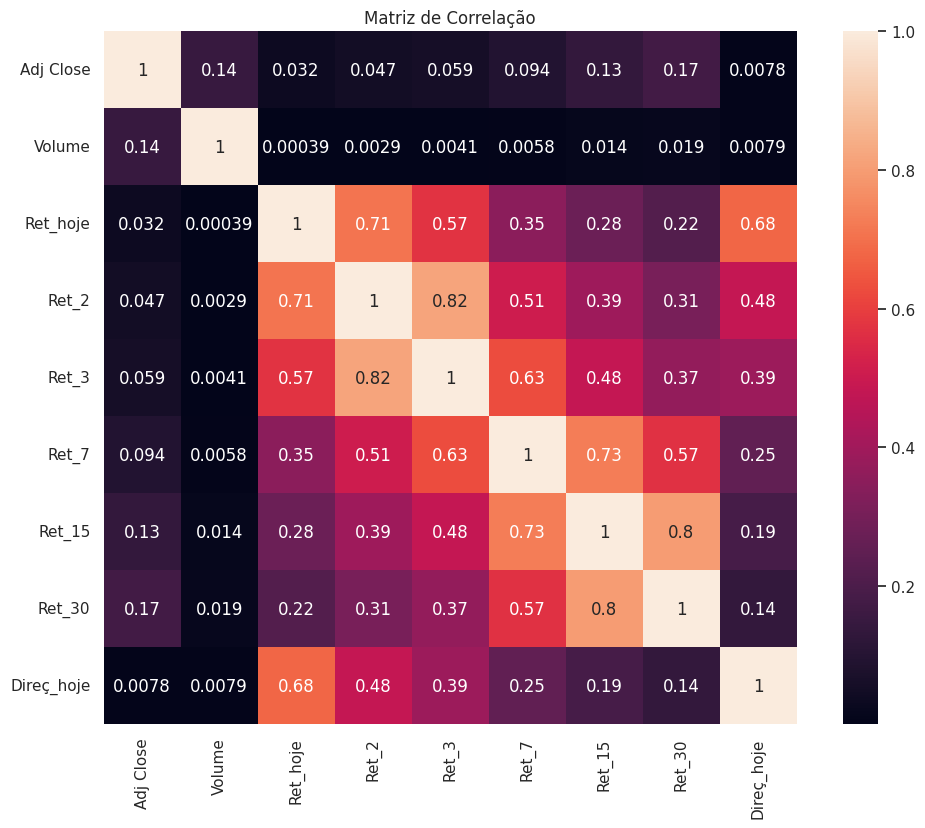

In [12]:
# Matriz de Correlação

# Ret_hoje apresenta alta correlação com o Ret_2 e a variável dependente preditiva Direç_hoje.
# É um candidato a sair do modelo pela possibilidade de apresentar erro de matriz singular.

corr_matrix = ibov.corr().abs()
fig, ax     = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Matriz de Correlação");

In [13]:
# Testar a Multicolinearidade das features via VIF
# https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

vif = pd.DataFrame()
vif['Feature'] = ibov.columns

vif['VIF'] = [variance_inflation_factor(ibov.values, i)
                  for i in range(len(ibov.columns))]

print(vif)

      Feature       VIF
0   Adj Close  1.846843
1      Volume  1.115917
2    Ret_hoje  2.554377
3       Ret_2  4.146410
4       Ret_3  3.756566
5       Ret_7  2.763148
6      Ret_15  4.153447
7      Ret_30  2.900380
8  Direç_hoje  2.427196


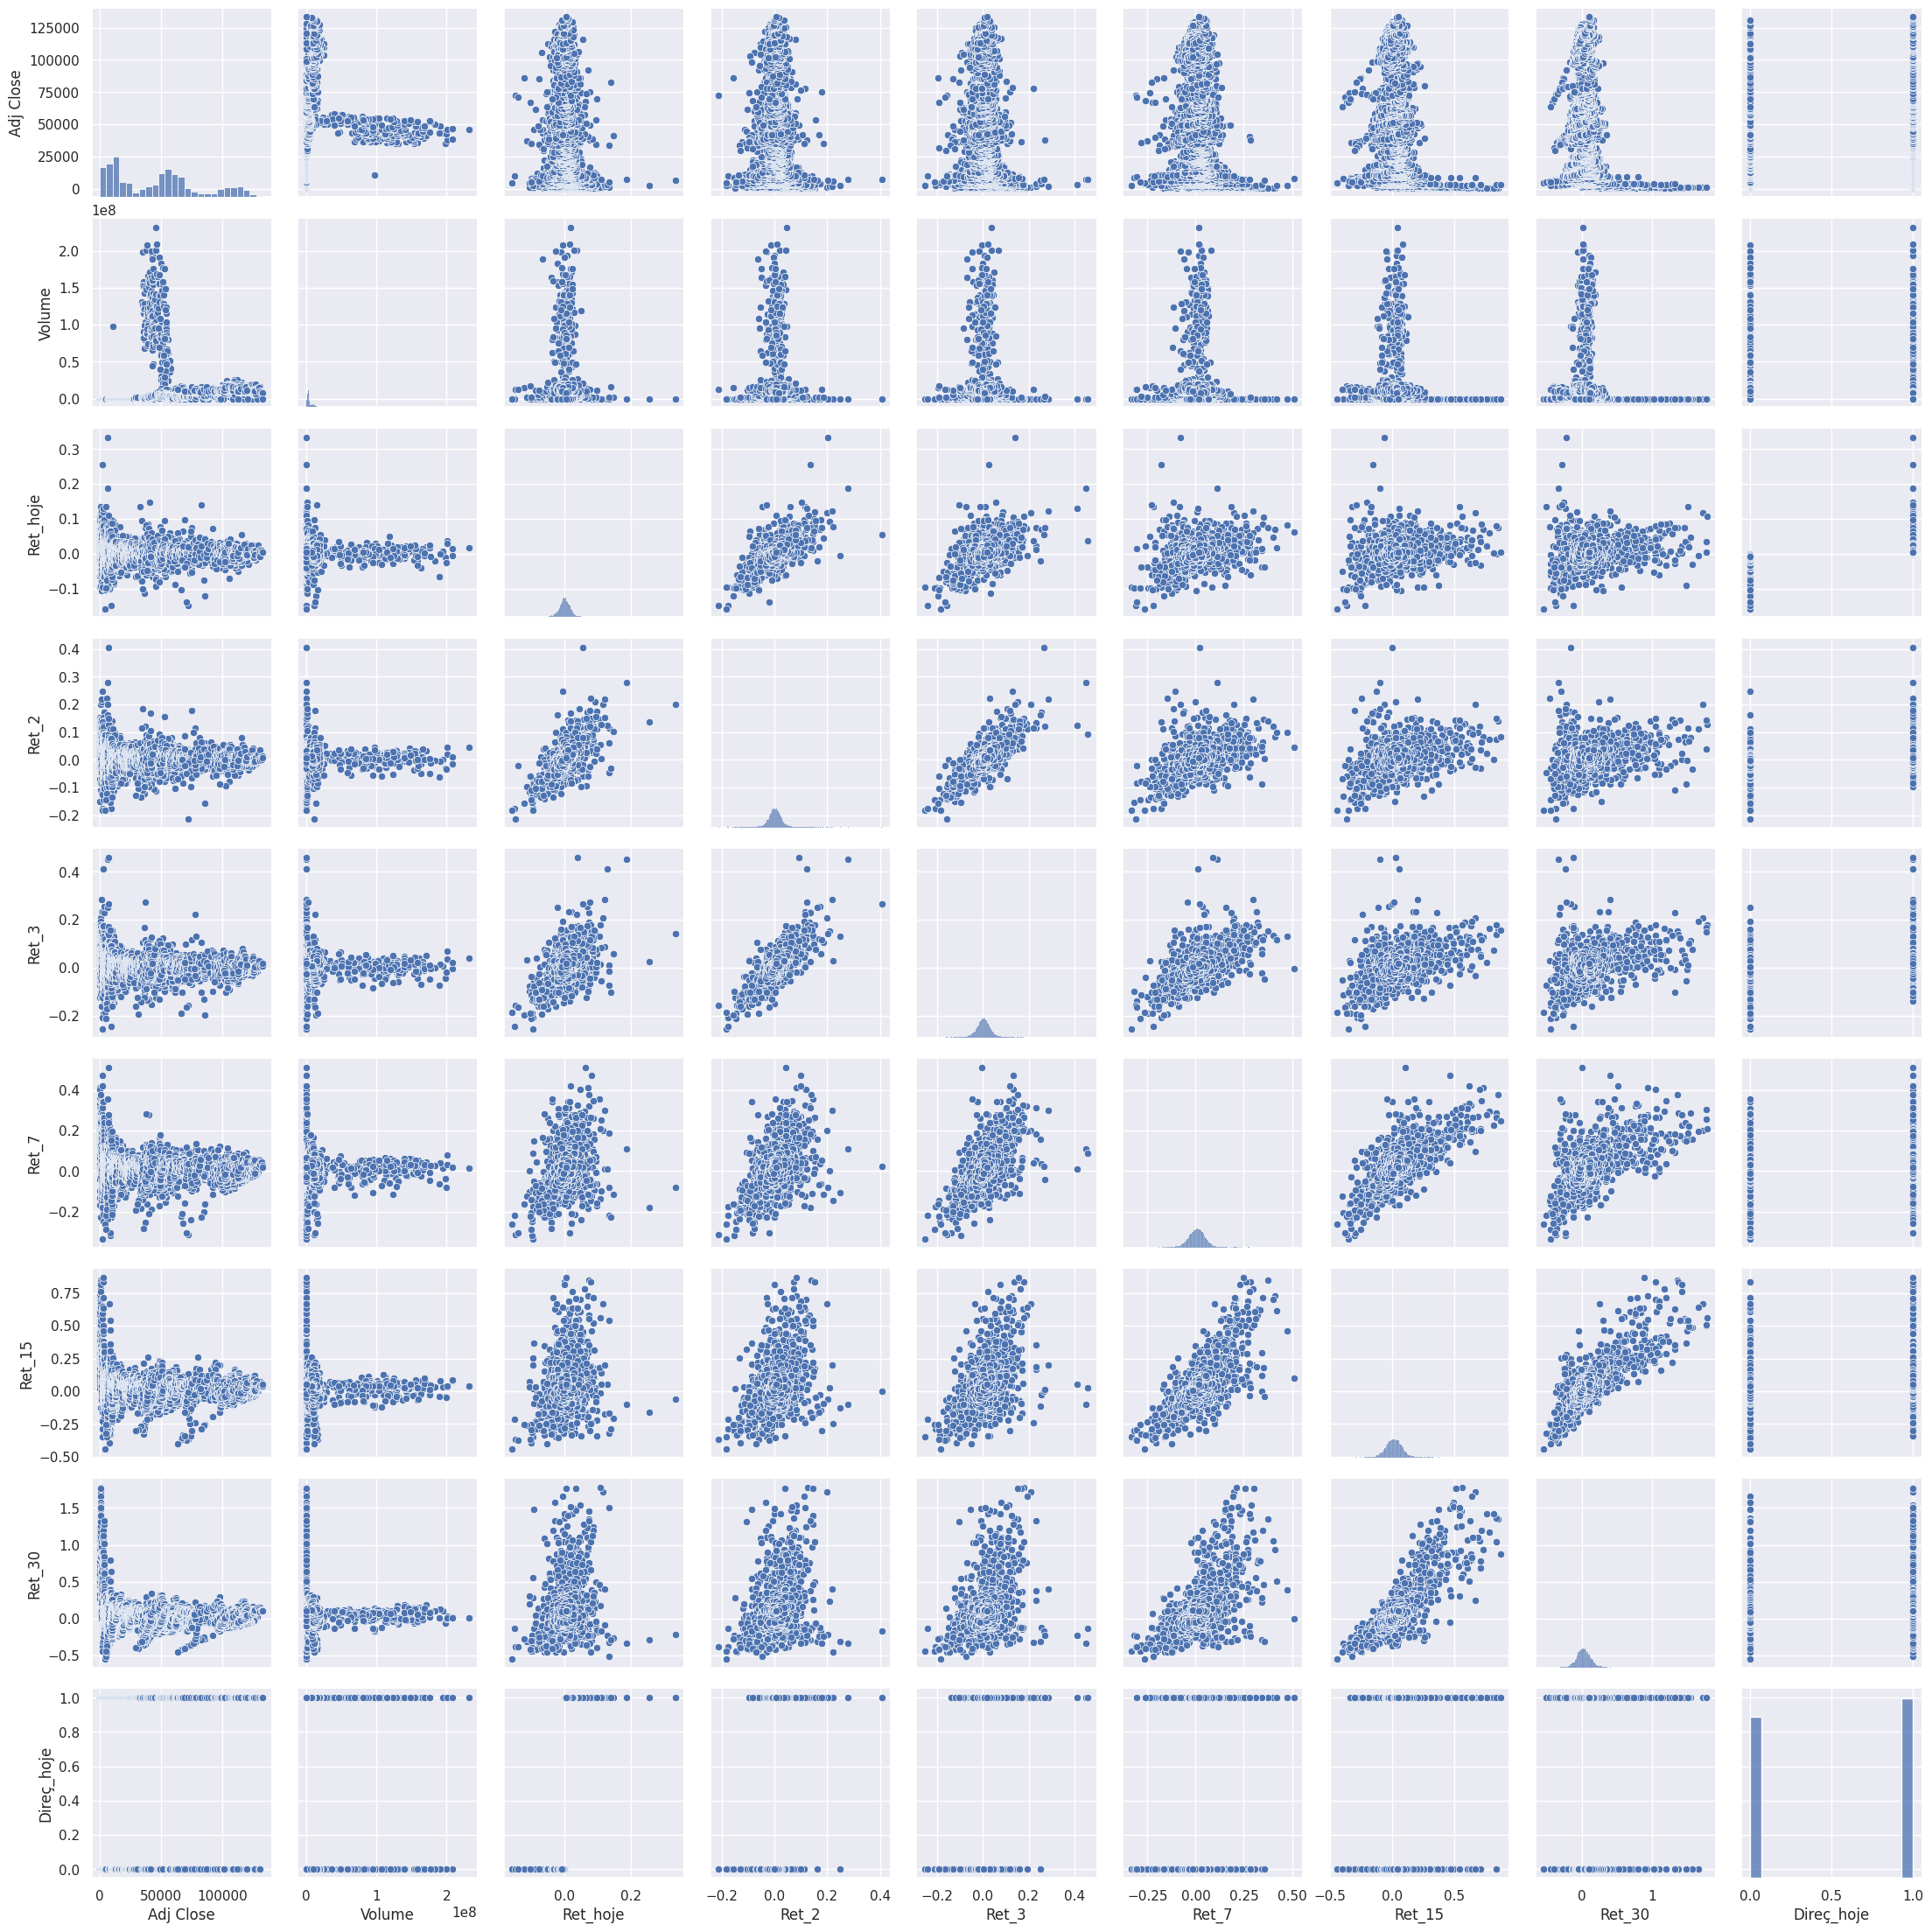

In [14]:
# Plot relacional entre as variáveis

sns.pairplot(ibov);

In [15]:
# APi reference: https://www.statsmodels.org/stable/api.html
# Multiple logistic reg exemple (statsmodel is best than sk learn cause the first show summary, with p-values): https://www.statology.org/statsmodels-logistic-regression/

# 4) Regressão Logística e Matriz de Confusão

## 4.1) Regressão Logística - todos os dados

In [16]:
# Treinar Modelo

# Essa Regressão utiliza todos os dados sem split.
# Como o alvo é a direção de hoje, caso o retorno de hoje seja colocado como feature, dará erro de 'singular matrix' (vide matriz de correlação),
# Para mais: https://www.quora.com/Im-getting-LinAlgError-singular-matrix-error-while-implementing-statsmodels-logistic-regression-sm-Logit-How-do-I-solve-this-error
# A Regressão logística multi pelo statsmodel trás a estatística sumária (pvalor, entre outros). Por isso a Reg Log multi não foi feita pelo sk learn.

dados = 'Direç_hoje ~ Ret_2 + Ret_3 + Ret_7 + Ret_15 + Ret_30 + Volume'
modelo = smf.logit(dados, data= ibov).fit()
# Display model summary
display(modelo.summary())

# Exibir as variáveis estatisticamente relevantes (p-valor < 0.05)
display(HTML('<h3>Feature (s) com predição estatisticamente relevante (<0.05):</h3>'))
display(pd.DataFrame({'p>|z|': modelo.pvalues[modelo.pvalues < 0.05]}))

Optimization terminated successfully.
         Current function value: 0.525105
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Direç_hoje   No. Observations:                 7486
Model:                          Logit   Df Residuals:                     7479
Method:                           MLE   Df Model:                            6
Date:                Tue, 26 Dec 2023   Pseudo R-squ.:                  0.2408
Time:                        14:00:56   Log-Likelihood:                -3930.9
converged:                       True   LL-Null:                       -5178.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0248      0.030      0.830      0.407      -0.034       0.083
Ret_2         63.3741      2.257     28.075      0.000      58.950      67.798
Ret_3         -3.3463      1.673     -2.000      0.046      -6.626      -0.066
Ret_7          0.6258      0.897      0.698      0.485      -1.132       2.383
Ret_15        -0.1744      0.660     -0.264      0.792      -1.469       1.120
Ret_30        -0.0108      0.323     -0.033      0.973      -0.643       0.622
Volume      4.033e-10   1.35e-09      0.300      0.764   -2.23e-09    3.04e-09
==============================================================================
"""

,p>|z|
Ret_2,1.963207e-173
Ret_3,4.554399e-02


A Estatística Z é uma medida estatística do grau do quanto o desvio padrão está acima (para valor positivo) ou baixo (para valor negativo) da média. Ela é equivalente ao Z Estatístico na Regressão Linear.

Os retornos de 2 e 3 dias apresentam pvalor abaixo de 0,05. Isso significa aceitar a hipótese de que são relevantes na previsão do modelo.

In [17]:
# Observar valores de coluna (pvalues, params, etc)

modelo.pvalues

Intercept     4.065624e-01
Ret_2        1.963207e-173
Ret_3         4.554399e-02
Ret_7         4.852432e-01
Ret_15        7.917055e-01
Ret_30        9.733132e-01
Volume        7.643041e-01
dtype: float64

### 4.1.1) Matriz de confusão - todos os dados

In [18]:
# Escala de previsão de probabilidade da alta no retorno, com base no training data

prob = modelo.predict()
prob[:10]

array([0.99462949, 0.9633758 , 0.95495111, 0.7205078 , 0.94853888,
       0.92966019, 0.18404933, 0.59950747, 0.97876111, 0.99920205])

In [19]:
# Criar o vetor que divide os dados na probabilidade de maior retorno positivo

labels = np.array([0 ]* len(ibov))
labels[prob>0.5] = 1

In [20]:
# Tipo de erro numa matriz de confusão:
# https://www.kdnuggets.com/2022/08/type-type-ii-errors-difference.html#:~:text=Type%20I%20error%20occurs%20when,as%20the%20False%20Negative%20Error.

In [21]:
# Criar tabela de confusão e classificador de probabilidades

def confusion_table(confusion_mtx):
    """Tabela dataframe da matriz de confusão"""
    confusao_df = pd.DataFrame({'y_pred=Queda': np.append(confusion_mtx[:, 0], confusion_mtx.sum(axis=0)[0]),
                                 'y_pred=Alta': np.append(confusion_mtx[:, 1], confusion_mtx.sum(axis=0)[1]),
                                 'Total': np.append(confusion_mtx.sum(axis=1), ''),
                                 '': ['y=Queda', 'y=Alta', 'Total']}).set_index('')
    return confusao_df


def observacoes_positivas(y):
    # Porcentagem de retornos diários históricos positivos
    proporcao_1 = ((y == 1).sum() / len(y))
    pct_1       = np.around(proporcao_1 *100, decimals=3)
    display(HTML('<p><h4>{}%</h4>dos retornos diários históricos são positivos</p>'.format(pct_1)))


# Classificador Probabilístico
# -------------------------------------------------

def acuracia(confusion_mtx):
    """Taxa de acerto, que mede a performance do modelo. Acurácia = previsões corretas / total de previsões"""
    return np.trace(confusion_mtx) / np.sum(confusion_mtx)

def taxa_erro_anterior(confusion_mtx):
    """A probabilidade anterior de que um resultado seja positivo"""
    return 1 - (np.sum(confusion_mtx[1, :]) / np.sum(confusion_mtx))

def taxa_erro_total(confusion_mtx):
    """Taxa de Erro, que mede a performance do modelo. """
    return 1 - np.trace(confusion_mtx) / np.sum(confusion_mtx)

def verdadeiro_positivo_tx(confusion_mtx):
    """Ou Sensibilidade: No conjunto real, a classe POSITIVA (retorno positivo ou negativo, respec.) procurada é prevista corretamente como POSITIVA (retorno positivo ou negativo, respec.)"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[1, :])

def falso_negativo_tx(confusion_mtx):
    """No conjunto real, a classe POSITIVA (retorno positivo) procurada é INcorretamente prevista como NEGATIVA (retorno negativo)"""
    return confusion_mtx[1, 0] / np.sum(confusion_mtx[1, :])

def falso_positivo_tx(confusion_mtx):
    """No conjunto real, a classe NEGATIVA (retorno negativo) procurada é INcorretamente prevista como POSITIVA (retorno positivo)"""
    return confusion_mtx[0, 1] / np.sum(confusion_mtx[0, :])

def verdadeiro_negativo_tx(confusion_mtx):
    """Ou Especificidade: No conjunto real, a classe NEGATIVA (retorno não positivo ou não negativo, respec.) procurada é prevista corretamente como NEGATIVA (retorno não positivo ou não negativo, respec.)"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[0, :])

def valor_preditivo_positivo(confusion_mtx):
    """Ou Precisão: A proporção de classe POSITIVA prevista corretamente como POSITIVA"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[:, 1])

def valor_preditivo_negativo(confusion_mtx):
    """A proporção de classe NEGATIVA prevista corretamente como NEGATIVA"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])

def classificador_probab(confusion_mtx):
    return pd.Series({'Acurácia': round(acuracia(confusion_mtx)*100, 2),
                      'Taxa de Erro Anterior': round(taxa_erro_anterior(confusion_mtx)*100, 2),
                      'Taxa de Erro Total': round(taxa_erro_total(confusion_mtx)*100,2),
                      'Verdadeiro Positivo tx (Sensibilidade)': round(verdadeiro_positivo_tx(confusion_mtx)*100,2),
                      'Falso Negativo tx': round(falso_negativo_tx(confusion_mtx)*100,2),
                      'Falso Positivo tx': round(falso_positivo_tx(confusion_mtx)*100,2),
                      'Verdadeiro Negativo tx (Especificidade)': round(verdadeiro_negativo_tx(confusion_mtx)*100,2),
                      'Valor Preditivo Positivo (Precisão)': round(valor_preditivo_positivo(confusion_mtx)*100,2),
                      'Valor Preditivo Negativo': round(valor_preditivo_negativo(confusion_mtx)*100,2)})

In [22]:
# Matriz de Confusão em linhas simples.

# A diagonal principal é a quantidade de previsões corretas
# A diagonal secundária é a quantidade de previsões erradas

confusion_matrix(labels, ibov['Direç_hoje'])

array([[2529,  879],
       [1012, 3066]])

In [23]:
# Calcular matriz de confusão
confusion_mtx = modelo.pred_table(threshold=0.5)

# Display da matriz de confusão
display(confusion_table(confusion_mtx))

,y_pred=Queda,y_pred=Alta,Total
,,,
y=Queda,2529.0,1012.0,3541.0
y=Alta,879.0,3066.0,3945.0
Total,3408.0,4078.0,


In [24]:
stats_logit = classificador_probab(confusion_mtx)
stats_logit

Acurácia                                   74.74
Taxa de Erro Anterior                      47.30
Taxa de Erro Total                         25.26
Verdadeiro Positivo tx (Sensibilidade)     77.72
Falso Negativo tx                          22.28
Falso Positivo tx                          28.58
Verdadeiro Negativo tx (Especificidade)    71.42
Valor Preditivo Positivo (Precisão)        75.18
Valor Preditivo Negativo                   74.21
dtype: float64

## 4.2) Regressão Logística - Antes e pós pandemia (fim de 2019) aos dias atuais com retornos de 2, 3 dias

Decidimos treinar os dados até o fim de 2019 (data de corte aproximada do início da pandemia Covid) e testar os dados posteriores até os dias atuais.

Como observado no teste de hipótese, o p-valor apresentou indicador relevante somente para os retornos de 2 e 3 dias posteriores, rejeitando os retornos de 7, 15, 30, preço de fechamento e volume.

In [25]:
# Criar a base de dados ibov_covid a partir do dataframe ibov

ibov_covid = ibov
ibov_covid

,Adj Close,Volume,Ret_hoje,Ret_2,Ret_3,Ret_7,Ret_15,Ret_30,Direç_hoje
Date,,,,,,,,,
1993-09-03,111.800003,0,0.017288,0.089669,0.159751,0.233996,0.510811,0.811994,1.0
1993-09-06,116.199997,0,0.039356,0.057325,0.132554,0.269945,0.598349,0.829921,1.0
1993-09-08,117.500000,0,0.011188,0.050984,0.069154,0.207605,0.520052,0.901295,1.0
1993-09-09,118.199997,0,0.005957,0.017212,0.057245,0.184369,0.473815,0.903382,1.0
1993-09-10,123.099998,0,0.041455,0.047660,0.059380,0.276971,0.548428,0.929467,1.0
...,...,...,...,...,...,...,...,...,...
2023-12-19,131851.000000,9429700,0.005851,0.012704,0.007712,0.037429,0.041987,0.112789,1.0
2023-12-20,130804.000000,10335800,-0.007941,-0.002136,0.004662,0.030634,0.037296,0.096723,0.0
2023-12-21,132182.000000,8681000,0.010535,0.002510,0.008376,0.045719,0.038098,0.109850,1.0


In [26]:
# Criar a coluna ano nos dados. Esse será o índice de corte até o fim de 2019

ibov_covid['Ano'] = ibov_covid.index.year
ibov_covid

,Adj Close,Volume,Ret_hoje,Ret_2,Ret_3,Ret_7,Ret_15,Ret_30,Direç_hoje,Ano
Date,,,,,,,,,,
1993-09-03,111.800003,0,0.017288,0.089669,0.159751,0.233996,0.510811,0.811994,1.0,1993
1993-09-06,116.199997,0,0.039356,0.057325,0.132554,0.269945,0.598349,0.829921,1.0,1993
1993-09-08,117.500000,0,0.011188,0.050984,0.069154,0.207605,0.520052,0.901295,1.0,1993
1993-09-09,118.199997,0,0.005957,0.017212,0.057245,0.184369,0.473815,0.903382,1.0,1993
1993-09-10,123.099998,0,0.041455,0.047660,0.059380,0.276971,0.548428,0.929467,1.0,1993
...,...,...,...,...,...,...,...,...,...,...
2023-12-19,131851.000000,9429700,0.005851,0.012704,0.007712,0.037429,0.041987,0.112789,1.0,2023
2023-12-20,130804.000000,10335800,-0.007941,-0.002136,0.004662,0.030634,0.037296,0.096723,0.0,2023
2023-12-21,132182.000000,8681000,0.010535,0.002510,0.008376,0.045719,0.038098,0.109850,1.0,2023


In [27]:
# Indexar os dados de treino até o fim de 2019

train_idx = ibov_covid.index[ibov_covid['Ano'] < 2020]
train_idx

DatetimeIndex(['1993-09-03', '1993-09-06', '1993-09-08', '1993-09-09',
               '1993-09-10', '1993-09-13', '1993-09-14', '1993-09-15',
               '1993-09-16', '1993-09-17',
               ...
               '2019-12-13', '2019-12-16', '2019-12-17', '2019-12-18',
               '2019-12-19', '2019-12-20', '2019-12-23', '2019-12-26',
               '2019-12-27', '2019-12-30'],
              dtype='datetime64[ns]', name='Date', length=6495, freq=None)

In [28]:
# Separar dados de treino
ibov_covid_train = ibov_covid.loc[train_idx]
print('ibov_covid_train shape: ', ibov_covid_train.shape)

# Separar dados de teste
ibov_covid_test = ibov_covid.drop(train_idx)
print('ibov_covid_test shape:', ibov_covid_test.shape)

# Arquivo base
print('ibov_covid_ shape:', ibov_covid.shape)

# Conferir tamanho dos arquivos
print('O tamanho dos dataframes de treino + teste é igual ao do arquivo base?', len(ibov_covid_train) + len(ibov_covid_test) == len(ibov_covid))

ibov_covid_train shape:  (6495, 10)
ibov_covid_test shape: (991, 10)
ibov_covid_ shape: (7486, 10)
O tamanho dos dataframes de treino + teste é igual ao do arquivo base? True


In [29]:
# Fit model

# Como o alvo é a direção de hoje, caso o retorno de hoje seja colocado como feature, dará erro de 'singular matrix',
# pois a matriz de correlação aponta 0.68 (relação alta) da relação. Vide: https://www.quora.com/Im-getting-LinAlgError-singular-matrix-error-while-implementing-statsmodels-logistic-regression-sm-Logit-How-do-I-solve-this-error

# Treinar modelo
dados2 = 'Direç_hoje ~ Ret_2 + Ret_3'
modelo2 = smf.logit(dados2, data= ibov_covid_train).fit()

# Display medidas estatísticas do modelo
display(modelo2.summary())

# Exibir as variáveis estatisticamente relevantes (p-valor < 0.05)
display(HTML('<h3>Feature (s) com predição estatisticamente relevante (<0.05):</h3>'))
display(pd.DataFrame({'p>|z|': modelo.pvalues[modelo.pvalues < 0.05]}))

Optimization terminated successfully.
         Current function value: 0.523188
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Direç_hoje   No. Observations:                 6495
Model:                          Logit   Df Residuals:                     6492
Method:                           MLE   Df Model:                            2
Date:                Tue, 26 Dec 2023   Pseudo R-squ.:                  0.2434
Time:                        14:00:57   Log-Likelihood:                -3398.1
converged:                       True   LL-Null:                       -4491.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0340      0.030      1.144      0.253      -0.024       0.092
Ret_2         62.7894      2.371     26.482      0.000      58.142      67.437
Ret_3         -4.2894      1.574     -2.724      0.006      -7.375      -1.203
==============================================================================
"""

,p>|z|
Ret_2,1.963207e-173
Ret_3,4.554399e-02


### 4.2.2) Matriz de Confusão - Antes e pós pandemia (fim de 2019) aos dias atuais com retornos de 2, 3 dias

In [30]:
# Escala de previsão de probabilidade da alta no retorno, com base no training data

prob2 = modelo2.predict()
prob2[:10]

array([0.99316595, 0.95541671, 0.94972144, 0.70456605, 0.94113168,
       0.92286709, 0.18687769, 0.60116781, 0.97786831, 0.99900883])

In [31]:
# Criar o vetor que divide os dados na probabilidade de maior retorno positivo

labels2 = np.array([0 ]* len(ibov_covid_train))
labels2[prob2>0.5] = 1

In [32]:
# Matriz de Confusão em linhas simples

confusion_matrix(labels2, ibov_covid_train['Direç_hoje'])

array([[2182,  756],
       [ 877, 2680]])

In [33]:
# Calcular matriz de confusão
confusion_mtx2 = modelo2.pred_table(threshold=0.5)

# Display da matriz de confusão
display(confusion_table(confusion_mtx2))

,y_pred=Queda,y_pred=Alta,Total
,,,
y=Queda,2182.0,877.0,3059.0
y=Alta,756.0,2680.0,3436.0
Total,2938.0,3557.0,


In [34]:
stats_covid = classificador_probab(confusion_mtx2)
stats_covid

Acurácia                                   74.86
Taxa de Erro Anterior                      47.10
Taxa de Erro Total                         25.14
Verdadeiro Positivo tx (Sensibilidade)     78.00
Falso Negativo tx                          22.00
Falso Positivo tx                          28.67
Verdadeiro Negativo tx (Especificidade)    71.33
Valor Preditivo Positivo (Precisão)        75.34
Valor Preditivo Negativo                   74.27
dtype: float64

# 4.3) Modelo Linear Discriminant Analysis e Matriz de Confusão

In [35]:
# Segmentar variáveis dependentes e independentes
X_train_lda = np.array(ibov_covid_train['Ret_2']).reshape(-1,1)
y_train_lda = np.array(ibov_covid_train['Direç_hoje'])
X_test_lda  = np.array(ibov_covid_test['Ret_2']).reshape(-1,1)
y_test_lda  = np.array(ibov_covid_test['Direç_hoje'])

In [36]:
# Porcentagem de observações positivas (retorno positivo)
observacoes_positivas(y_test_lda)

In [37]:
# Treinar modelo
lda = LinearDiscriminantAnalysis()
modelo3 = lda.fit(X_train_lda, y_train_lda)

#Previsão do modelo
modelo3_pred_lda = modelo3.predict(X_test_lda)

# Display medidas estatísticas do modelo
#display(modelo3.summary())

In [38]:
# Matriz de Confusão

confusion_mtx3 = confusion_matrix(y_test_lda, modelo3_pred_lda)
confusion_mtx3

array([[344, 138],
       [103, 406]])

In [39]:
# Calcular matriz de confusão
#confusion_mtx3 = modelo3.pred_table(threshold=0.5)

# Display da matriz de confusão
display(confusion_table(confusion_mtx3))

,y_pred=Queda,y_pred=Alta,Total
,,,
y=Queda,344,138,482
y=Alta,103,406,509
Total,447,544,


In [40]:
stats_lda = classificador_probab(confusion_mtx3)
stats_lda

Acurácia                                   75.68
Taxa de Erro Anterior                      48.64
Taxa de Erro Total                         24.32
Verdadeiro Positivo tx (Sensibilidade)     79.76
Falso Negativo tx                          20.24
Falso Positivo tx                          28.63
Verdadeiro Negativo tx (Especificidade)    71.37
Valor Preditivo Positivo (Precisão)        74.63
Valor Preditivo Negativo                   76.96
dtype: float64

# 4.4) Modelo Quadratic Discriminant Analysis e Matriz de Confusão

In [41]:
# Segmentar variáveis dependentes e independentes
X_train_qda = np.array(ibov_covid_train['Ret_2']).reshape(-1,1)
y_train_qda = np.array(ibov_covid_train['Direç_hoje'])
X_test_qda  = np.array(ibov_covid_test['Ret_2']).reshape(-1,1)
y_test_qda  = np.array(ibov_covid_test['Direç_hoje'])

In [42]:
# Porcentagem de observações positivas (retorno positivo)
observacoes_positivas(y_test_qda)

In [43]:
# Treinar modelo
qda = QuadraticDiscriminantAnalysis()
modelo4 = qda.fit(X_train_qda, y_train_qda)

#Previsão do modelo
modelo4_pred_qda = modelo4.predict(X_test_qda)

# Display medidas estatísticas do modelo
#display(modelo3.summary())

In [44]:
# Matriz de Confusão

confusion_mtx4 = confusion_matrix(y_test_qda, modelo4_pred_qda)
confusion_mtx4

array([[348, 134],
       [113, 396]])

In [45]:
# Display da matriz de confusão
display(confusion_table(confusion_mtx4))

,y_pred=Queda,y_pred=Alta,Total
,,,
y=Queda,348,134,482
y=Alta,113,396,509
Total,461,530,


In [46]:
# Estatísticas do Modelo

stats_qda = classificador_probab(confusion_mtx4)
stats_qda

Acurácia                                   75.08
Taxa de Erro Anterior                      48.64
Taxa de Erro Total                         24.92
Verdadeiro Positivo tx (Sensibilidade)     77.80
Falso Negativo tx                          22.20
Falso Positivo tx                          27.80
Verdadeiro Negativo tx (Especificidade)    72.20
Valor Preditivo Positivo (Precisão)        74.72
Valor Preditivo Negativo                   75.49
dtype: float64

# 5) Modelo KNN com K=1 e Matriz de Confusão

In [47]:
# Segmentar variáveis dependentes e independentes
X_train_knn = np.array(ibov_covid_train['Ret_2']).reshape(-1,1)
y_train_knn = np.array(ibov_covid_train['Direç_hoje'])
X_test_knn  = np.array(ibov_covid_test['Ret_2']).reshape(-1,1)
y_test_knn  = np.array(ibov_covid_test['Direç_hoje'])

In [48]:
# Porcentagem de observações positivas (retorno positivo)
observacoes_positivas(y_test_knn)

In [49]:
# Treinar modelo

K = 1
modelo5 = KNeighborsClassifier(n_neighbors=K).fit(X_train_knn, y_train_knn)
modelo5_pred_knn = modelo5.predict(X_test_knn)

# qda = QuadraticDiscriminantAnalysis()
# modelo4 = lda.fit(X_train_qda, y_train_qda)

#Previsão do modelo
# modelo4_pred_qda = modelo4.predict(X_test_qda)

# Display medidas estatísticas do modelo
#display(modelo3.summary())

In [50]:
# Matriz de Confusão

confusion_mtx5 = confusion_matrix(y_test_knn, modelo5_pred_knn)
confusion_mtx5

array([[293, 189],
       [192, 317]])

In [51]:
# Display da matriz de confusão
display(confusion_table(confusion_mtx5))

,y_pred=Queda,y_pred=Alta,Total
,,,
y=Queda,293,189,482
y=Alta,192,317,509
Total,485,506,


In [52]:
# Estatísticas do Modelo

stats_knn = classificador_probab(confusion_mtx5)
stats_knn

Acurácia                                   61.55
Taxa de Erro Anterior                      48.64
Taxa de Erro Total                         38.45
Verdadeiro Positivo tx (Sensibilidade)     62.28
Falso Negativo tx                          37.72
Falso Positivo tx                          39.21
Verdadeiro Negativo tx (Especificidade)    60.79
Valor Preditivo Positivo (Precisão)        62.65
Valor Preditivo Negativo                   60.41
dtype: float64

# 6) Comparação dos métodos

In [53]:
stats_metodos = pd.DataFrame({'Logit geral' : stats_logit,
                              'Logit covid' : stats_covid,
                              'LDA'         : stats_lda,
                              'QDA'         : stats_qda,
                              'KNN_1'       : stats_knn}).T
display(stats_metodos.T)

,Logit geral,Logit covid,LDA,QDA,KNN_1
Acurácia,74.74,74.86,75.68,75.08,61.55
Taxa de Erro Anterior,47.30,47.10,48.64,48.64,48.64
Taxa de Erro Total,25.26,25.14,24.32,24.92,38.45
Verdadeiro Positivo tx (Sensibilidade),77.72,78.00,79.76,77.80,62.28
Falso Negativo tx,22.28,22.00,20.24,22.20,37.72
Falso Positivo tx,28.58,28.67,28.63,27.80,39.21
Verdadeiro Negativo tx (Especificidade),71.42,71.33,71.37,72.20,60.79
Valor Preditivo Positivo (Precisão),75.18,75.34,74.63,74.72,62.65
Valor Preditivo Negativo,74.21,74.27,76.96,75.49,60.41


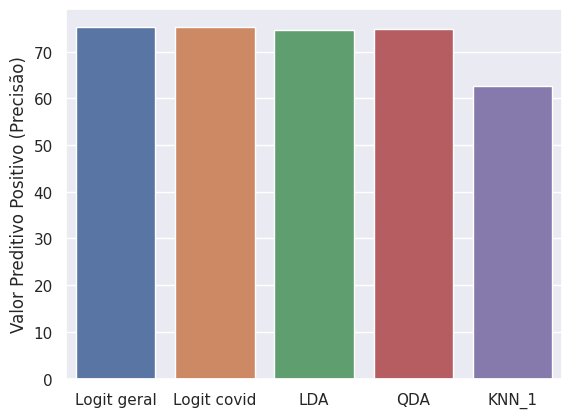

In [54]:
# Visualização gráfica da Precisão

ax = sns.barplot(x=stats_metodos.index, y=stats_metodos['Valor Preditivo Positivo (Precisão)'])

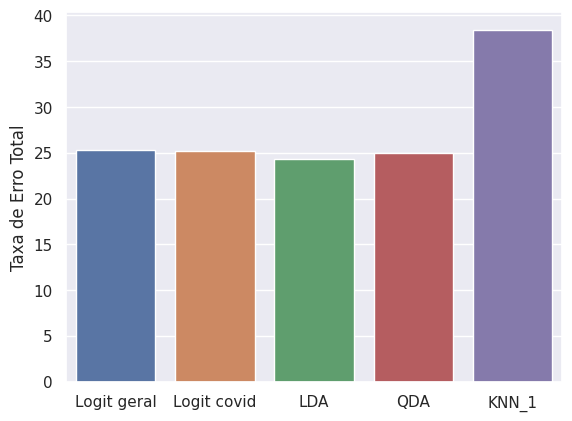

In [55]:
# Visualização gráfica da Taxa de Erro Total

ax = sns.barplot(x=stats_metodos.index, y=stats_metodos['Taxa de Erro Total'])

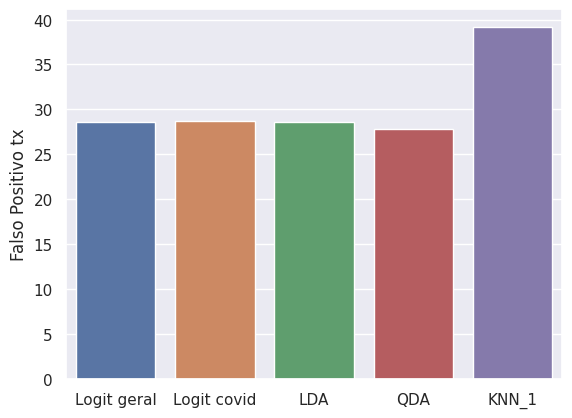

In [56]:
# Visualização gráfica da Taxa de Falso Positivo

ax = sns.barplot(x=stats_metodos.index, y=stats_metodos['Falso Positivo tx'])

# 7) Modelos condensados no mesmo algoritmo, previsão do Retorno em 2 dias e demonstração do KNN com k =1,3,10,15 e 20

In [57]:
# 1) Split dos dados
# Separar dados de treino (Mesmo processo usado para separar dados do covid)
ibov_covid_train = ibov_covid.loc[train_idx]

# Separar dados de teste
ibov_covid_test = ibov_covid.drop(train_idx)

# Conferir tamanho dos arquivos
print('O tamanho dos dataframes de treino + teste é igual ao do arquivo base?', len(ibov_covid_train) + len(ibov_covid_test) == len(ibov_covid))


# 2) Segmentar variáveis dependentes e independentes
X_train = np.array(ibov_covid_train['Ret_2']).reshape(-1,1)
y_train = np.array(ibov_covid_train['Direç_hoje'])
X_test  = np.array(ibov_covid_test['Ret_2']).reshape(-1,1)
y_test  = np.array(ibov_covid_test['Direç_hoje'])


# 3) Modelos
# 3.1) Logit
logit        = LogisticRegression()
modelo_logit = logit.fit(X_train, y_train)

# 3.2) Logit Covid
logit_covid        = LogisticRegression()
modelo_logit_covid = logit_covid.fit(X_train, y_train)

# 3.3) LDA
lda         = LinearDiscriminantAnalysis()
modelo_lda   = lda.fit(X_train, y_train)

# 3.4) QDA
qda         = QuadraticDiscriminantAnalysis()
modelo_qda   = qda.fit(X_train, y_train)

# 3.5) KNN_1
K = 1
modelo_knn_1 = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)

# 3.6) KNN_3
K = 3
modelo_knn_3 = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)

# 3.7) KNN_10
K = 10
modelo_knn_10 = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)

# 3.8) KNN_15
K = 15
modelo_knn_15 = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)

# 3.9) KNN_20
K = 20
modelo_knn_20 = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)

stats_modelos = {'Logit':       modelo_logit,
                 'Logit Covid': modelo_logit_covid,
                 'LDA':         modelo_lda,
                 'QDA':         modelo_qda,
                 'KNN_1':       modelo_knn_1,
                 'KNN_3':       modelo_knn_3,
                 'KNN_10':      modelo_knn_10,
                 'KNN_15':      modelo_knn_15,
                 'KNN_20':      modelo_knn_20}
scaled = ['knn_1', 'knn_3', 'knn_10', 'knn_15', 'knn_20']

# Previsão
for k in stats_modelos:
    # Predict
    if k in scaled:
        y_pred = stats_modelos[k].predict(preprocessing.scale(X_test))
    else:
        y_pred = stats_modelos[k].predict(X_test)
    # Confusion table
    display(HTML('<h3>{}</h3>'.format(k)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    # Classifier stats
    display(pd.DataFrame(classificador_probab(confusion_mtx)))
    print('_________________________________________________')

O tamanho dos dataframes de treino + teste é igual ao do arquivo base? True


,y_pred=Queda,y_pred=Alta,Total
,,,
y=Queda,315,167,482
y=Alta,88,421,509
Total,403,588,


,0
Acurácia,74.27
Taxa de Erro Anterior,48.64
Taxa de Erro Total,25.73
Verdadeiro Positivo tx (Sensibilidade),82.71
Falso Negativo tx,17.29
Falso Positivo tx,34.65
Verdadeiro Negativo tx (Especificidade),65.35
Valor Preditivo Positivo (Precisão),71.60
Valor Preditivo Negativo,78.16


_________________________________________________


,y_pred=Queda,y_pred=Alta,Total
,,,
y=Queda,315,167,482
y=Alta,88,421,509
Total,403,588,


,0
Acurácia,74.27
Taxa de Erro Anterior,48.64
Taxa de Erro Total,25.73
Verdadeiro Positivo tx (Sensibilidade),82.71
Falso Negativo tx,17.29
Falso Positivo tx,34.65
Verdadeiro Negativo tx (Especificidade),65.35
Valor Preditivo Positivo (Precisão),71.60
Valor Preditivo Negativo,78.16


_________________________________________________


,y_pred=Queda,y_pred=Alta,Total
,,,
y=Queda,344,138,482
y=Alta,103,406,509
Total,447,544,


,0
Acurácia,75.68
Taxa de Erro Anterior,48.64
Taxa de Erro Total,24.32
Verdadeiro Positivo tx (Sensibilidade),79.76
Falso Negativo tx,20.24
Falso Positivo tx,28.63
Verdadeiro Negativo tx (Especificidade),71.37
Valor Preditivo Positivo (Precisão),74.63
Valor Preditivo Negativo,76.96


_________________________________________________


,y_pred=Queda,y_pred=Alta,Total
,,,
y=Queda,348,134,482
y=Alta,113,396,509
Total,461,530,


,0
Acurácia,75.08
Taxa de Erro Anterior,48.64
Taxa de Erro Total,24.92
Verdadeiro Positivo tx (Sensibilidade),77.80
Falso Negativo tx,22.20
Falso Positivo tx,27.80
Verdadeiro Negativo tx (Especificidade),72.20
Valor Preditivo Positivo (Precisão),74.72
Valor Preditivo Negativo,75.49


_________________________________________________


,y_pred=Queda,y_pred=Alta,Total
,,,
y=Queda,216,266,482
y=Alta,211,298,509
Total,427,564,


,0
Acurácia,51.87
Taxa de Erro Anterior,48.64
Taxa de Erro Total,48.13
Verdadeiro Positivo tx (Sensibilidade),58.55
Falso Negativo tx,41.45
Falso Positivo tx,55.19
Verdadeiro Negativo tx (Especificidade),44.81
Valor Preditivo Positivo (Precisão),52.84
Valor Preditivo Negativo,50.59


_________________________________________________


,y_pred=Queda,y_pred=Alta,Total
,,,
y=Queda,198,284,482
y=Alta,184,325,509
Total,382,609,


,0
Acurácia,52.77
Taxa de Erro Anterior,48.64
Taxa de Erro Total,47.23
Verdadeiro Positivo tx (Sensibilidade),63.85
Falso Negativo tx,36.15
Falso Positivo tx,58.92
Verdadeiro Negativo tx (Especificidade),41.08
Valor Preditivo Positivo (Precisão),53.37
Valor Preditivo Negativo,51.83


_________________________________________________


,y_pred=Queda,y_pred=Alta,Total
,,,
y=Queda,247,235,482
y=Alta,224,285,509
Total,471,520,


,0
Acurácia,53.68
Taxa de Erro Anterior,48.64
Taxa de Erro Total,46.32
Verdadeiro Positivo tx (Sensibilidade),55.99
Falso Negativo tx,44.01
Falso Positivo tx,48.76
Verdadeiro Negativo tx (Especificidade),51.24
Valor Preditivo Positivo (Precisão),54.81
Valor Preditivo Negativo,52.44


_________________________________________________


,y_pred=Queda,y_pred=Alta,Total
,,,
y=Queda,144,338,482
y=Alta,108,401,509
Total,252,739,


,0
Acurácia,54.99
Taxa de Erro Anterior,48.64
Taxa de Erro Total,45.01
Verdadeiro Positivo tx (Sensibilidade),78.78
Falso Negativo tx,21.22
Falso Positivo tx,70.12
Verdadeiro Negativo tx (Especificidade),29.88
Valor Preditivo Positivo (Precisão),54.26
Valor Preditivo Negativo,57.14


_________________________________________________


,y_pred=Queda,y_pred=Alta,Total
,,,
y=Queda,155,327,482
y=Alta,101,408,509
Total,256,735,


,0
Acurácia,56.81
Taxa de Erro Anterior,48.64
Taxa de Erro Total,43.19
Verdadeiro Positivo tx (Sensibilidade),80.16
Falso Negativo tx,19.84
Falso Positivo tx,67.84
Verdadeiro Negativo tx (Especificidade),32.16
Valor Preditivo Positivo (Precisão),55.51
Valor Preditivo Negativo,60.55


_________________________________________________


In [58]:
stats_metodos.T

,Logit geral,Logit covid,LDA,QDA,KNN_1
Acurácia,74.74,74.86,75.68,75.08,61.55
Taxa de Erro Anterior,47.30,47.10,48.64,48.64,48.64
Taxa de Erro Total,25.26,25.14,24.32,24.92,38.45
Verdadeiro Positivo tx (Sensibilidade),77.72,78.00,79.76,77.80,62.28
Falso Negativo tx,22.28,22.00,20.24,22.20,37.72
Falso Positivo tx,28.58,28.67,28.63,27.80,39.21
Verdadeiro Negativo tx (Especificidade),71.42,71.33,71.37,72.20,60.79
Valor Preditivo Positivo (Precisão),75.18,75.34,74.63,74.72,62.65
Valor Preditivo Negativo,74.21,74.27,76.96,75.49,60.41


# 8) Conclusão

A Regressão Logística pelo Logit com split de dados antes e pós covid apresentou a melhor Precisão, e essa é a estatística mais importante nesse modelo que prevê retorno.

Além disso, a Taxa de Erro Anterior é a mais baixa pelo Logit splitado comparado aos outros modelos.

A Sensiblidade, ou verdadeiro positivo, apresenta o segundo maior valor pelo logit splitado.

Por fim, o modelo Knn_1 com somente k=1 vizinhos apresenta a pior precisão entre os modelos. Quando aumentamos o número de vizinhos conforme a tabela acima para 3,10,15 e 20, a precisão piora gradativamente. Logo, o knn não é um modelo indicado para previsão de retornos.